In [1]:
## 数据读取+特征转换
import polars as pl
import sys
sys.path.append("..")
from utils.quant import *

pldf = pl.read_csv("../data/cleaned/csi300_stock_feats.csv")
# pldf = pldf.group_by('instrument').map_groups(func_ts_date)
pldf = func_ts_date(pldf.filter(pl.col('instrument') == 'SH600009'))
# print(pldf)

SH600009


In [3]:
df = pldf.to_pandas()
label = 'LABEL0'
features = [col for col in df.columns if col.isupper() and col!=label]
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(['instrument', 'datetime'], inplace=True)
df.dropna(inplace=True)
df[label] = df.groupby('instrument')[label].transform(lambda x: (x - x.mean()) / x.std())

In [4]:
years = df.index.get_level_values('datetime').year
df_1617 = df[years.isin([2016, 2017])].copy()   # train
df_18 = df[years == 2018].copy()    # val
df_19 = df[years == 2019].copy()    # test

In [5]:
model = BaseModel.from_name('lgb')
model.train(df_1617, df_18, features, label)

[20]	train's l2: 0.558225	valid's l2: 1.57654
[40]	train's l2: 0.558225	valid's l2: 1.57654
[60]	train's l2: 0.558225	valid's l2: 1.57654
[80]	train's l2: 0.558225	valid's l2: 1.57654
[100]	train's l2: 0.558225	valid's l2: 1.57654
[120]	train's l2: 0.558225	valid's l2: 1.57654
[140]	train's l2: 0.558225	valid's l2: 1.57654
[160]	train's l2: 0.558225	valid's l2: 1.57654
[180]	train's l2: 0.558225	valid's l2: 1.57654
[200]	train's l2: 0.558225	valid's l2: 1.57654
[220]	train's l2: 0.558225	valid's l2: 1.57654
[240]	train's l2: 0.558225	valid's l2: 1.57654
[260]	train's l2: 0.558225	valid's l2: 1.57654
[280]	train's l2: 0.558225	valid's l2: 1.57654
[300]	train's l2: 0.558225	valid's l2: 1.57654
[320]	train's l2: 0.558225	valid's l2: 1.57654
[340]	train's l2: 0.558225	valid's l2: 1.57654
[360]	train's l2: 0.558225	valid's l2: 1.57654
[380]	train's l2: 0.558225	valid's l2: 1.57654
[400]	train's l2: 0.558225	valid's l2: 1.57654
[420]	train's l2: 0.558225	valid's l2: 1.57654
[440]	train's l2:

<IPython.core.display.Javascript object>

OrderedDict([('sharperatio', None)])
OrderedDict([(2019, -0.0267723781159227)])
AutoOrderedDict([('len', 238), ('drawdown', 2.853817460988975), ('moneydown', 28590.047578392783)])


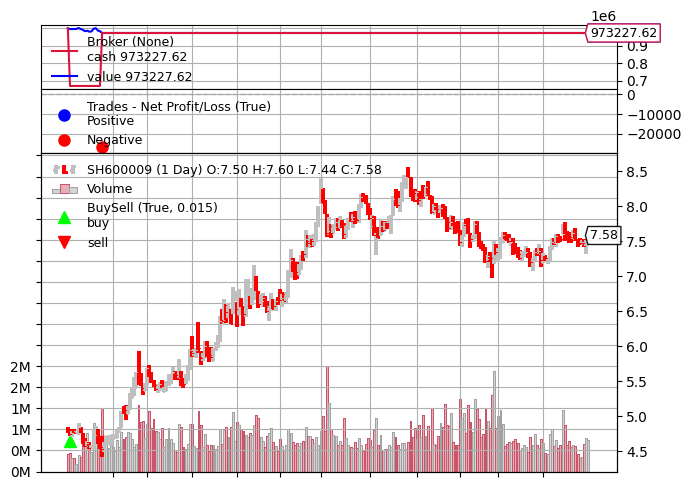

In [6]:
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline

# 创建Cerebro并添加数据
cerebro = bt.Cerebro()
for instrument, group in model.pred(df_19, features).groupby('instrument'):
    group = group.reset_index(level=0, drop=True)
    cerebro.adddata(MyPandasData(dataname=group), name=instrument)
cerebro.addstrategy(MyStrategy)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="SharpeRatio")
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="AnnualReturn")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="DrawDown")

cerebro.broker.set_cash(1e6) # 设定初始资金
cerebro.broker.setcommission(commission=6e-4) # 设定手续费
result = cerebro.run()
plt.figure()
cerebro.plot(style='bar')
plt.show()
print(result[0].analyzers.SharpeRatio.get_analysis())
print(result[0].analyzers.AnnualReturn.get_analysis())
print(result[0].analyzers.DrawDown.get_analysis()['max'])